In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import re
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt


### Clear day-ahead load

In [2]:
# Specify the directory you want to use
directory = './DAM/Load'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [3]:
values = ['CA ISO-TAC', 'MWD-TAC', 'PGE-TAC','SCE-TAC','SDGE-TAC','VEA-TAC']
df_selected = combined_df[combined_df['TAC_AREA_NAME'].isin(values)]
df_sorted = df_selected.sort_values(by=['OPR_DT', 'OPR_HR',]).reset_index(drop=True)

In [4]:
CAISO = df_sorted[df_sorted['TAC_AREA_NAME']=='CA ISO-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[24:8784].reset_index(drop=True)
Zone1 = df_sorted[df_sorted['TAC_AREA_NAME']=='PGE-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[24:8784].reset_index(drop=True)
Zone2_values = ['MWD-TAC','SCE-TAC','VEA-TAC']
Zone2_sep = df_sorted[df_sorted['TAC_AREA_NAME'].isin(Zone2_values)]
Zone2 = Zone2_sep.groupby(['INTERVALSTARTTIME_GMT'])['MW'].sum().iloc[24:8784].reset_index()
Zone3 = df_sorted[df_sorted['TAC_AREA_NAME']=='SDGE-TAC'][['INTERVALSTARTTIME_GMT','MW']].iloc[24:8784].reset_index(drop=True)

In [5]:
train_pre = pd.concat([CAISO['INTERVALSTARTTIME_GMT'], CAISO['MW'], Zone1['MW'], Zone2['MW'], Zone3['MW']], axis=1)
train_pre.columns = ['INTERVALSTARTTIME_GMT', 'CAISO', 'Zone1', 'Zone2', 'Zone3']
train_pre['CAISO'] = train_pre[['Zone1', 'Zone2', 'Zone3']].sum(axis=1)
train_pre['INTERVALSTARTTIME_GMT'] = pd.to_datetime(train_pre['INTERVALSTARTTIME_GMT'])
train_pre.set_index('INTERVALSTARTTIME_GMT', inplace=True)

In [6]:
DAMLoad = train_pre.resample('5T').ffill()

In [7]:
train_pre['CAISO'].max()

51317.22

In [8]:
DAMLoad

,CAISO,Zone1,Zone2,Zone3
INTERVALSTARTTIME_GMT,,,,
2022-01-01 08:00:00+00:00,22630.73,10247.46,10307.27,2076.0
2022-01-01 08:05:00+00:00,22630.73,10247.46,10307.27,2076.0
2022-01-01 08:10:00+00:00,22630.73,10247.46,10307.27,2076.0
2022-01-01 08:15:00+00:00,22630.73,10247.46,10307.27,2076.0
2022-01-01 08:20:00+00:00,22630.73,10247.46,10307.27,2076.0
...,...,...,...,...
2023-01-01 06:40:00+00:00,23038.80,10464.78,10262.02,2312.0
2023-01-01 06:45:00+00:00,23038.80,10464.78,10262.02,2312.0
2023-01-01 06:50:00+00:00,23038.80,10464.78,10262.02,2312.0


### K-Means training

In [9]:
reshaped_data = train_pre[['CAISO', 'Zone1', 'Zone2', 'Zone3']].values.reshape(-1, 24*4)/max(train_pre['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

kmeans = KMeans(n_clusters= 8, random_state=0).fit(reshaped_data)

labels = kmeans.labels_  # the label of the cluster each data point belongs to

/Users/ningkunzheng/opt/anaconda3/envs/STESTS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


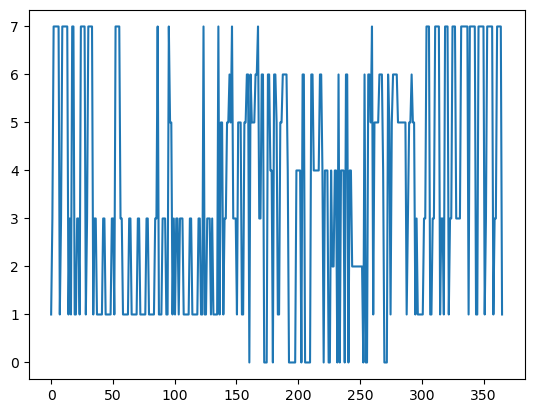

In [10]:
# Generate some data
x1 = np.linspace(0, 365, 365)
y1 = labels

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Show the plot
plt.show()

### Clear real-time load

In [11]:
# Specify the directory you want to use
directory = './RTD/Load'

dataframes = []  # list to store dataframes
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

In [12]:
combined_df = combined_df.sort_values(by=['INTERVALSTARTTIME_GMT', 'TAC_AREA_NAME']).reset_index(drop=True)

In [13]:
values = ['CA ISO-TAC', 'MWD-TAC', 'PGE-TAC','SCE-TAC','SDGE-TAC','VEA-TAC']
df_selected = combined_df[combined_df['TAC_AREA_NAME'].isin(values)]
df_selected = df_selected[df_selected['XML_DATA_ITEM']=='SYS_FCST_5MIN_MW'].reset_index(drop=True)[['INTERVALSTARTTIME_GMT', 'TAC_AREA_NAME', 'MW']]

In [14]:
df_selected['INTERVALSTARTTIME_GMT'] = pd.to_datetime(df_selected['INTERVALSTARTTIME_GMT'])
df_pivot = df_selected.pivot(index='INTERVALSTARTTIME_GMT', columns='TAC_AREA_NAME', values='MW')
df_resampled = df_pivot.resample('5T').asfreq()
df_interpolated = df_resampled.interpolate(method='linear')

In [15]:
CAISO = df_interpolated['CA ISO-TAC'][288:105397]
Zone1 = df_interpolated['PGE-TAC'][288:105397]
Zone2 = (df_interpolated['MWD-TAC']+df_interpolated['SCE-TAC']+df_interpolated['VEA-TAC'])[288:105397]
Zone3 = df_interpolated['SDGE-TAC'][288:105397]
RTDLoad = pd.concat([CAISO, Zone1, Zone2, Zone3], axis=1)
RTDLoad.columns = ['CAISO', 'Zone1', 'Zone2', 'Zone3']
RTDLoad['CAISO'] = RTDLoad[['Zone1', 'Zone2', 'Zone3']].sum(axis=1)


### RTD load noise

In [16]:
RTDLoadNoise = (DAMLoad - RTDLoad)/max(DAMLoad['CAISO'])
RTDLoadNoise

,CAISO,Zone1,Zone2,Zone3
INTERVALSTARTTIME_GMT,,,,
2022-01-01 08:00:00+00:00,0.031935,0.014809,0.017319,-0.000194
2022-01-01 08:05:00+00:00,0.033319,0.015399,0.018057,-0.000137
2022-01-01 08:10:00+00:00,0.034752,0.016062,0.018733,-0.000043
2022-01-01 08:15:00+00:00,0.036272,0.016793,0.019416,0.000063
2022-01-01 08:20:00+00:00,0.037344,0.017179,0.020243,-0.000078
...,...,...,...,...
2023-01-01 06:40:00+00:00,0.040708,0.026899,0.010435,0.003375
2023-01-01 06:45:00+00:00,0.043866,0.028112,0.012104,0.003650
2023-01-01 06:50:00+00:00,0.045313,0.028746,0.012731,0.003836


In [23]:
RTDLoadNoise['CAISO'].min()

-0.027725001471241045

In [18]:
### find closest date to each cluster centroid
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reshaped_data)
noise_list = []
for i in closest:
    selected_rows = RTDLoadNoise.loc[RTDLoadNoise.index.date == train_pre.index.date[24*i]].values
    noise_list.append(selected_rows)
noise_list = np.stack(noise_list)
# j = 0
# for i in closest:
#     selected_rows = RTDLoadNoise.loc[RTDLoadNoise.index.date == train_pre.index.date[24*i]]
#     selected_rows.to_csv(f"./noise/cluster_{j}.csv")
#     j=j+1

In [19]:
noise_list[:, :, 0].shape

(8, 288)

In [24]:
noise_list[:, :, 0].min()

-0.023363502543590715

### ADS day-ahead load prediction

In [25]:
ADSLoad = pd.read_csv("./Processed Data/Load.csv")[['1','2','3']]
ADSLoad['CAISO'] = ADSLoad[['1', '2', '3']].sum(axis=1)
ADSLoad = ADSLoad[['CAISO', '1', '2', '3']]
reshaped_ADSLoad = ADSLoad.values.reshape(-1, 24*4)/max(ADSLoad['CAISO'])  # reshapes data to have 365 data points each of 24*4=96 features

In [26]:
ADSLoad['CAISO'].max()/train_pre['CAISO'].max()

1.248450188844992

In [27]:
ADSLoad_C = pd.read_csv("./Processed Data/Load.csv")

In [28]:
ADSLoad_C = ADSLoad_C.iloc[:,1:8]/(ADSLoad['CAISO'].max()/train_pre['CAISO'].max())
ADSLoad_C.to_csv('Processed Data/Load_C.csv')

In [29]:
ADSLoad_C

,1,2,3,4,5,6,7
0,10372.393801,11283.621987,1869.517920,34050.217125,17591.410692,10963.245568,1482.638247
1,9590.505178,10447.249010,1742.961008,32770.230135,17149.262495,10686.101952,1421.762771
2,9011.344706,9950.808699,1605.190193,32162.276364,17090.789998,10562.749013,1389.723047
3,8660.693952,9594.030348,1493.051158,32020.500583,17144.456536,10594.788737,1360.887295
4,8588.600567,9456.099335,1456.205475,32362.524641,17834.912597,10828.678726,1352.877364
...,...,...,...,...,...,...,...
8779,14972.048678,15877.725981,3087.027448,40358.037870,22627.254377,14518.219599,1686.090497
8780,14680.838021,15695.612188,3034.962895,39247.861419,22096.195945,14579.896068,1669.269642
8781,14265.469427,15456.699973,2904.401018,38063.993602,21030.875108,14403.677584,1620.409062
8782,13550.688006,14857.677275,2741.799417,36405.937863,20119.344948,13898.250931,1550.722662


In [30]:
ADSLoadC = ADSLoad_C[['1','2','3']]
ADSLoadC['CAISO'] = ADSLoadC[['1', '2', '3']].sum(axis=1)
ADSLoadC = ADSLoadC[['CAISO', '1', '2', '3']]

/var/folders/f2/rxpbf6rd2wjbpqry4k3rs6fr0000gn/T/ipykernel_18988/1359669237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADSLoadC['CAISO'] = ADSLoadC[['1', '2', '3']].sum(axis=1)


In [31]:
reshaped_ADSLoad

array([[0.45843352, 0.20212307, 0.21987984, ..., 0.21992401, 0.24020825,
        0.04187804],
       [0.45144062, 0.19712058, 0.21890398, ..., 0.21835495, 0.23788006,
        0.04301747],
       [0.45011146, 0.19781447, 0.21491425, ..., 0.22350383, 0.21634401,
        0.04069178],
       ...,
       [0.43936696, 0.19263336, 0.20857043, ..., 0.23267482, 0.2554846 ,
        0.04567094],
       [0.48129203, 0.20811127, 0.23389376, ..., 0.23980968, 0.26519459,
        0.04573338],
       [0.4931575 , 0.21379227, 0.24023431, ..., 0.24264184, 0.27193504,
        0.04835563]])

In [32]:
predictions = kmeans.predict(reshaped_ADSLoad)
predictions

array([6, 6, 5, 7, 6, 6, 6, 6, 6, 5, 7, 5, 6, 6, 6, 5, 7, 7, 6, 6, 6, 6,
       6, 7, 7, 6, 6, 6, 5, 5, 7, 1, 5, 5, 6, 6, 5, 7, 1, 5, 5, 5, 5, 5,
       7, 1, 5, 6, 6, 6, 6, 7, 7, 5, 6, 6, 6, 6, 7, 7, 5, 5, 5, 5, 5, 7,
       1, 5, 5, 5, 5, 5, 7, 7, 5, 5, 5, 5, 5, 7, 1, 5, 5, 5, 5, 5, 7, 1,
       5, 5, 5, 5, 5, 5, 7, 6, 6, 6, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 5, 7, 7, 5, 5, 5, 5, 0, 6, 5, 0, 0, 0, 0, 6, 5, 7, 6, 6,
       6, 6, 6, 5, 7, 5, 6, 6, 6, 5, 7, 7, 6, 4, 0, 6, 0, 0, 0, 4, 0, 0,
       0, 4, 6, 6, 4, 2, 2, 4, 4, 6, 5, 0, 4, 4, 4, 2, 4, 0, 4, 4, 4, 4,
       4, 4, 6, 0, 0, 6, 0, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2,
       4, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2,
       4, 2, 4, 2, 2, 2, 2, 4, 2, 4, 4, 4, 4, 0, 6, 0, 0, 4, 4, 4, 4, 0,
       4, 2, 2, 2, 2, 2, 4, 2, 2, 4, 4, 4, 0, 0, 4, 4, 4, 4, 2, 4, 0, 4,
       4, 4, 2, 4, 6, 6, 4, 4, 0, 0, 0, 5, 5, 0, 0, 6, 6, 6, 5, 5, 6, 6,
       6, 6, 0, 6, 5, 6, 6, 6, 0, 0, 6, 5, 6, 6, 6,

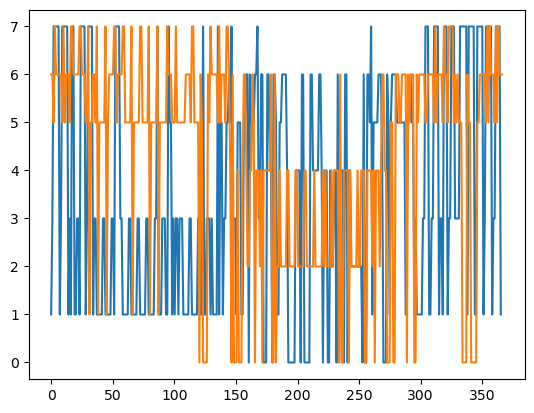

In [33]:
# Generate some data
x2 = np.linspace(0, 366, 366)
y2 = predictions

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(x1, y1)

# Plot the data
ax.plot(x2, y2)

# Show the plot
plt.show()

### Apply noise to ADS load base on prediciton

In [34]:
ADSLoad['CAISO'].mean()

36103.0301625683

In [35]:
ADSLoadC['CAISO'].mean()

28918.27842644579

In [36]:
ADSLoad['CAISO'].mean()/ADSLoadC['CAISO'].mean()

1.2484501888449917

In [37]:
ADSLoad['CAISO'].max()/ADSLoadC['CAISO'].max()

1.2484501888449921

In [38]:
max(ADSLoad['CAISO'])

64066.993

In [39]:
noise_list_ADS = max(ADSLoad['CAISO'])*noise_list
noise_list_ADS[1]

array([[ 3.42967994e+03,  2.25413924e+03,  9.81506569e+02,
         1.94034128e+02],
       [ 3.15338542e+03,  2.06117878e+03,  9.20344995e+02,
         1.71861653e+02],
       [ 2.97138636e+03,  1.96161487e+03,  8.65737783e+02,
         1.44033698e+02],
       ...,
       [ 8.30843601e+02,  7.88770829e+02,  2.30963285e+00,
         3.97631385e+01],
       [ 6.79980880e+02,  7.35399584e+02, -6.75786087e+01,
         1.21599048e+01],
       [ 5.67857568e+02,  6.60342758e+02, -8.85525719e+01,
        -3.93261809e+00]])

In [40]:
noise_list_ADSC = max(ADSLoadC['CAISO'])*noise_list
noise_list_ADSC[1]

array([[ 2.74715e+03,  1.80555e+03,  7.86180e+02,  1.55420e+02],
       [ 2.52584e+03,  1.65099e+03,  7.37190e+02,  1.37660e+02],
       [ 2.38006e+03,  1.57124e+03,  6.93450e+02,  1.15370e+02],
       ...,
       [ 6.65500e+02,  6.31800e+02,  1.85000e+00,  3.18500e+01],
       [ 5.44660e+02,  5.89050e+02, -5.41300e+01,  9.74000e+00],
       [ 4.54850e+02,  5.28930e+02, -7.09300e+01, -3.15000e+00]])

In [41]:
ADSLoad_repeated = ADSLoad.loc[ADSLoad.index.repeat(12)].reset_index(drop=True)

In [42]:
ADSLoadC_repeated = ADSLoadC.loc[ADSLoad.index.repeat(12)].reset_index(drop=True)

In [45]:
ADSLoadCDouble_repeated = ADSLoadC.loc[ADSLoad.index.repeat(12)].reset_index(drop=True)

In [43]:
-noise_list_ADSC[predictions[0]]+ADSLoadC_repeated[0:288].values

array([[21855.64370765,  8932.80380129, 11133.30198658,  1789.53791978],
       [21913.49370765,  8967.31380129, 11141.72198658,  1804.45791978],
       [22039.04370765,  9050.97380129, 11165.14198658,  1822.92791978],
       ...,
       [23835.43270617, 10223.67879708, 11570.62939376,  2041.12451533],
       [23936.09270617, 10277.64879708, 11598.89939376,  2059.54451533],
       [24008.40270617, 10331.38379708, 11603.04439376,  2073.97451533]])

In [40]:
ADSRTDLoad = np.empty((0, 4))
for i in range(len(reshaped_ADSLoad)):
    adjust = -noise_list_ADS[predictions[i]]+ADSLoad_repeated[i*288:i*288+288].values
    ADSRTDLoad = np.vstack((ADSRTDLoad, adjust))

In [47]:
ADSRTDLoadC = np.empty((0, 4))
for i in range(len(reshaped_ADSLoad)):
    adjustC = -noise_list_ADSC[predictions[i]]+ADSLoadC_repeated[i*288:i*288+288].values
    ADSRTDLoadC = np.vstack((ADSRTDLoadC, adjustC))

In [53]:
ADSRTDLoadCTriple = np.empty((0, 4))
for i in range(len(reshaped_ADSLoad)):
    adjustC = -noise_list_ADSC[predictions[i]]*3+ADSLoadC_repeated[i*288:i*288+288].values
    ADSRTDLoadCTriple = np.vstack((ADSRTDLoadCTriple, adjustC))

In [42]:
len(ADSRTDLoadC)

105408

In [43]:
ADSLoad_rest = pd.read_csv("./Processed Data/Load.csv")[['4','5','6','7']]
new_index = np.arange(ADSLoad_rest.index.min(), ADSLoad_rest.index.max() + 1, 1/12)
ADSLoad_rest_reindexed = ADSLoad_rest.reindex(new_index)
ADSLoad_rest_interpolated = ADSLoad_rest_reindexed.interpolate(method='linear')
ADSLoad_rest_interpolated.values

array([[42510.        , 21962.        , 13687.066     ,  1851.        ],
       [42376.83333333, 21916.        , 13658.23266667,  1844.66666667],
       [42243.66666667, 21870.        , 13629.39933333,  1838.33333333],
       ...,
       [42868.        , 24105.        , 16593.274     ,  1826.        ],
       [42868.        , 24105.        , 16593.274     ,  1826.        ],
       [42868.        , 24105.        , 16593.274     ,  1826.        ]])

In [51]:
ADSLoadC_rest = pd.read_csv("./Processed Data/Load_C.csv")[['4','5','6','7']]
new_index = np.arange(ADSLoadC_rest.index.min(), ADSLoadC_rest.index.max() + 1, 1/12)
ADSLoadC_rest_reindexed = ADSLoadC_rest.reindex(new_index)
ADSLoadC_rest_interpolated = ADSLoadC_rest_reindexed.interpolate(method='linear')
ADSLoadC_rest_interpolated.values

array([[34050.21712506, 17591.41069162, 10963.24556822,  1482.63824744],
       [33943.55154252, 17554.56500854, 10940.15026687,  1477.56529107],
       [33836.88595998, 17517.71932546, 10917.05496552,  1472.4923347 ],
       ...,
       [34336.9726586 , 19307.9389273 , 13291.09815374,  1462.61341967],
       [34336.9726586 , 19307.9389273 , 13291.09815374,  1462.61341967],
       [34336.9726586 , 19307.9389273 , 13291.09815374,  1462.61341967]])

In [45]:
ADSLoad_RTD = np.hstack((ADSRTDLoad, ADSLoad_rest_interpolated))
np.savetxt("realtimeload_R.csv", ADSLoad_RTD, delimiter=",")


In [46]:
ADSLoadC_RTD = np.hstack((ADSRTDLoadC, ADSLoadC_rest_interpolated))
np.savetxt("realtimeload_C_R.csv", ADSLoadC_RTD, delimiter=",")

In [54]:
ADSLoadCTriple_RTD = np.hstack((ADSRTDLoadCTriple, ADSLoadC_rest_interpolated))
np.savetxt("realtimeload_C_R_Triple.csv", ADSLoadCTriple_RTD, delimiter=",")

In [47]:
ADSRTDLoadC

array([[21855.64370765,  8932.80380129, 11133.30198658,  1789.53791978],
       [21913.49370765,  8967.31380129, 11141.72198658,  1804.45791978],
       [22039.04370765,  9050.97380129, 11165.14198658,  1822.92791978],
       ...,
       [26961.79131853, 11389.49463259, 13198.76002978,  2373.53665616],
       [27062.45131853, 11443.46463259, 13227.03002978,  2391.95665616],
       [27134.76131853, 11497.19963259, 13231.17502978,  2406.38665616]])

In [48]:
df_interpolated

TAC_AREA_NAME,CA ISO-TAC,MWD-TAC,PGE-TAC,SCE-TAC,SDGE-TAC,VEA-TAC
INTERVALSTARTTIME_GMT,,,,,,
2021-12-31 08:00:00+00:00,22062.04,212.02,9385.72,9336.17,2002.17,70.63
2021-12-31 08:05:00+00:00,21971.23,211.99,9347.57,9292.39,1996.91,70.80
2021-12-31 08:10:00+00:00,21877.07,211.80,9305.30,9250.18,1992.05,70.25
2021-12-31 08:15:00+00:00,21781.70,211.40,9258.01,9210.23,1987.69,70.47
2021-12-31 08:20:00+00:00,21672.74,210.66,9202.12,9171.41,1977.69,69.99
...,...,...,...,...,...,...
2023-01-01 07:35:00+00:00,20993.08,206.81,8771.84,8897.09,2051.90,63.99
2023-01-01 07:40:00+00:00,20941.46,206.81,8756.46,8867.53,2049.83,63.81
2023-01-01 07:45:00+00:00,20734.96,206.82,8604.44,8807.64,2054.20,63.85


In [49]:
ADSLoadC_rest_interpolated

,4,5,6,7
0.000000,34050.217125,17591.410692,10963.245568,1482.638247
0.083333,33943.551543,17554.565009,10940.150267,1477.565291
0.166667,33836.885960,17517.719325,10917.054966,1472.492335
0.250000,33730.220377,17480.873642,10893.959664,1467.419378
0.333333,33623.554795,17444.027959,10870.864363,1462.346422
...,...,...,...,...
8783.583333,34336.972659,19307.938927,13291.098154,1462.613420
8783.666667,34336.972659,19307.938927,13291.098154,1462.613420
8783.750000,34336.972659,19307.938927,13291.098154,1462.613420
8783.833333,34336.972659,19307.938927,13291.098154,1462.613420
